In [77]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
train_csv = pd.read_csv('./data/written_name_train_v2.csv')
val_csv = pd.read_csv('./data/written_name_validation_v2.csv')
train_img_dir = './data/train_v2/train'
val_img_dir = './data/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)
print(len(train_csv))

330961 41370
330961


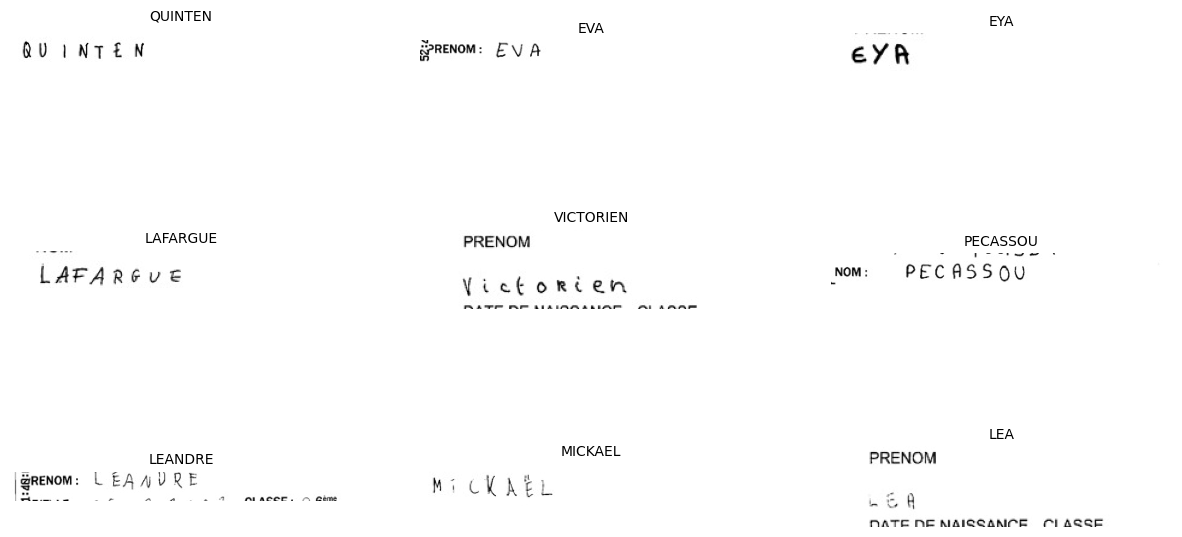

In [79]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.choice(data_csv.index)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

In [80]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


In [81]:
train_csv = train_csv.sample(frac=0.001, random_state=42).reset_index(drop=True)
val_csv = val_csv.sample(frac=0.001, random_state=42).reset_index(drop=True)

print(train_csv)

             FILENAME       IDENTITY
0    TRAIN_233051.jpg          MANON
1     TRAIN_88894.jpg      EMELIANOV
2     TRAIN_99639.jpg  DOUAA-SABRINE
3    TRAIN_246055.jpg         NATHAN
4    TRAIN_264573.jpg        CANAMAS
..                ...            ...
326   TRAIN_91600.jpg       AMBROISE
327  TRAIN_163370.jpg       SAYASANE
328  TRAIN_282172.jpg       MOUHSSIM
329  TRAIN_330064.jpg          DYLAN
330   TRAIN_22066.jpg        LORYANE

[331 rows x 2 columns]


In [109]:
import os
import cv2
import numpy as np
import pandas as pd

image_size = 28

def normalize_image(image_path):
    # Załaduj obraz w skali szarości
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Sprawdź, czy obraz został poprawnie załadowany
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Zmień rozmiar obrazu (jeśli konieczne)
    image = cv2.resize(image, (image_size, image_size))
    
    # Znormalizuj wartości pikseli do zakresu [0, 1]
    normalized_image = image / 255.0
    
    return normalized_image

def normalize_images(image_dir, image_csv):
    normalized_images = []
    labels = []
    
    for idx, row in image_csv.iterrows():
        image_path = os.path.join(image_dir, row['FILENAME'])
        try:
            normalized_image = normalize_image(image_path)
            normalized_images.append(normalized_image)
            labels.append(row['IDENTITY'])
        except FileNotFoundError as e:
            print(e)
    
    return np.array(normalized_images), np.array(labels)

# Normalizacja danych treningowych
train_images, train_labels = normalize_images(train_img_dir, train_csv)

# Normalizacja danych walidacyjnych
val_images, val_labels = normalize_images(val_img_dir, val_csv)

# Sprawdź kształt znormalizowanych danych
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")

# Opcjonalnie: dodaj kanał dla zgodności z wejściem do sieci CNN
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

print(f"Train images shape after expanding dims: {train_images.shape}")
print(f"Validation images shape after expanding dims: {val_images.shape}")

Train images shape: (331, 28, 28)
Validation images shape: (41, 28, 28)
Train images shape after expanding dims: (331, 28, 28, 1)
Validation images shape after expanding dims: (41, 28, 28, 1)


In [83]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [84]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [85]:
train_labels_encoded = [encode_to_label(label) for label in train_labels]
val_labels_encoded = [encode_to_label(label) for label in val_labels]
print()

In [86]:
# from tensorflow.keras.utils import to_categorical

# train_labels_encoded_categorical = to_categorical(train_labels)
# val_labels_encoded_categorical = to_categorical(val_labels)


In [87]:
from keras import ops

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

In [112]:
###############################################
# https://keras.io/examples/vision/captcha_ocr/
###############################################

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )

In [89]:
from tensorflow.keras.layers import Layer
# Making CTC Function
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [110]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape

def make_model():
    inp = Input(shape=(image_size, image_size, 1), dtype=np.float32, name='input_data')
    labels = Input(shape=[max_str_len], name='input_label')
    input_len = Input(shape=[1], name='input_length')
    label_len = Input(shape=[1],dtype=np.int64,name='label_length')
    x=Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(inp)
    x=MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1')(x)
    x=Dropout(0.3, name='dropout')(x)
    x=Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.3)(x)
    new_shape=((image_size//4),(image_size//4)*128)
    x=Reshape(new_shape)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=Dense(num_of_characters+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_len,label_len)
    model=Model([inp,labels,input_len,label_len],output)
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                            decay=1e-6,
                            momentum=0.9,
                            nesterov=True,
                            clipnorm=5)

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

    model.compile(optimizer=sgd)
    return model
# Trenowanie modelu
# history = model.fit(train_images, train_labels_encoded, epochs=10,
#                     validation_data=(val_images, val_labels_encoded))


In [111]:
model=make_model()
model.summary()

/Users/tomasz/Projects/Projekty PWr/projekt_naukowo_wzdrozeniowy/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 28, 28,    │        640 │ input_data[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 14, 14,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 7, 7, 128) │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 7, 7, 128) │          0 │ max_pooling2d_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 7, 896)    │          0 │ dropout_32[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 7, 64)     │     57,408 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 7, 64)     │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_26    │ (None, 7, 256)    │    197,632 │ dropout_33[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (None, 7, 128)    │    164,352 │ bidirectional_26… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_label         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_output        │ (None, 7, 31)     │      3,999 │ bidirectional_27… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (CTCLayer)  │ (None, 1)         │          0 │ input_label[0][0… │
│                     │                   │            │ Dense_output[0][

 Total params: 497,887 (1.90 MB)

 Trainable params: 497,887 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
print(train_images.shape)
train_labels_encoded = np.array(train_labels_encoded)
print(train_labels_encoded.shape)

print(val_images.shape)
val_labels_encoded = np.array(val_labels_encoded)
print(val_labels_encoded.shape)

(331, 28, 28, 1)
(331, 24)
(41, 28, 28, 1)
(41, 24)
